# Optimal filter tutorial
This script demonstrates how the optimal filtering is typically done. Using a preloaded set pulses and noise data. 

We first load the optimal_filter.py file with the relevant functions + some necessary packages:

In [1]:
from optimal_filter import *

import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

Then, we load the two data inputs: a stack of pulses and a noise timestream

In [2]:
pulses = np.load('pulses.npy')    # MxN array of M pulses of length N
noise = np.load('noise.npy')      # 3 sec of timestream noise data taken at 1 Msample/sec

We then initialize some parameters

In [3]:
pw = 1024                           # pulse window length
len_onesided = round(pw / 2) + 1    # length of the onesided fft, this includes the DC and Nyquist term.
sf = 1e6                            # sampling frequency of data
exclude_dc = True                   # whether or not to exclude the DC value of the pulse and noise models in the optimal filter
nr_req_segments = 1000              # how many noise segments we want to average for our noise model. It may be that less are returned than desired because of pulses present in the noise data.
threshold = None                    # threshold for pulse detection in the the noise data 

We then compute our pulse and noise models, as well as a normalisation constant

In [4]:
norm_pulse, norm_pulse_fft, norm_pulse_psd = pulse_model(pulses, pw, sf)
noise_psd, freqs = noise_model(noise, pw, sf, threshold=None, nr_req_segments=1000)

We plot these models to get an idea of their magnitudes, both real and imaginary

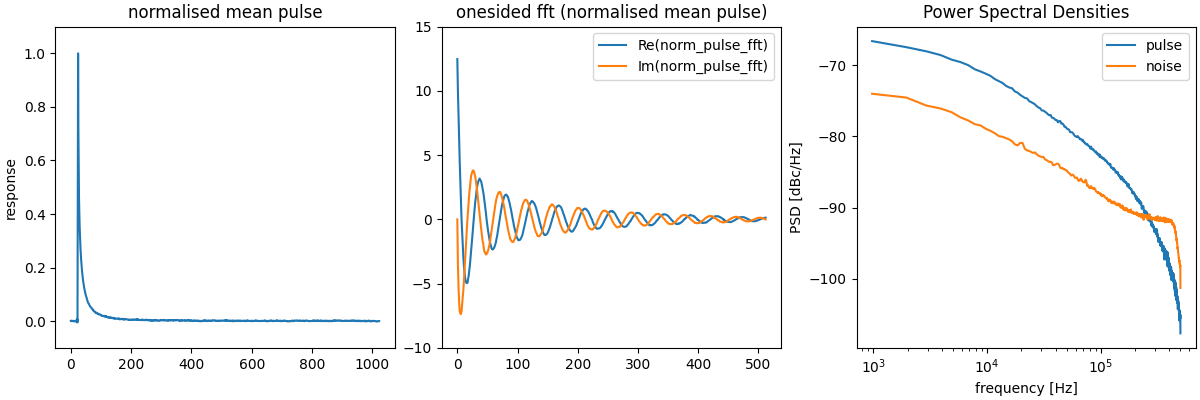

In [5]:
fig, axes = plt.subplot_mosaic('abc', figsize=(12, 4), sharey=False, constrained_layout=True)
ax = axes['a']
ax.plot(norm_pulse)
ax.set_ylim([-.1, 1.1])
ax.set_ylabel('response')
ax.set_title('normalised mean pulse')
ax = axes['b']
ax.plot(norm_pulse_fft.real, label='Re(norm_pulse_fft)')
ax.plot(norm_pulse_fft.imag, label='Im(norm_pulse_fft)')
ax.set_ylim([-10, 15])
ax.set_title('onesided fft (normalised mean pulse)')
_ = ax.legend()
ax = axes['c']
_ = ax.semilogx(freqs[1:], 10*np.log10(norm_pulse_psd[1:]), label='pulse')
_ = ax.semilogx(freqs[1:], 10*np.log10(noise_psd[1:]), label='noise')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [dBc/Hz]')
ax.set_title('Power Spectral Densities')
ax.legend()

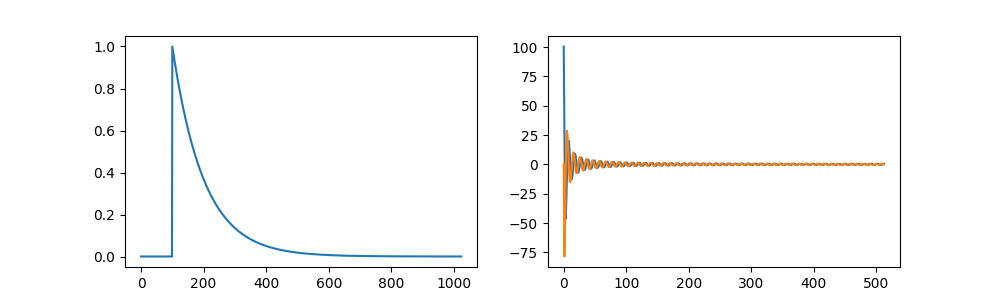

In [6]:
def expulse(t, tau):
    return np.exp(-t/tau)

t = np.arange(pw-100)
pulse = expulse(t, 100)
pulse = np.hstack((np.zeros(100), pulse))
fft_pulse = fft(pulse)[:len_onesided]
fig, axes = plt.subplot_mosaic('ab', figsize=(10, 3))
ax = axes['a']
ax.plot(pulse)
ax = axes['b']
ax.plot(fft_pulse.real)
ax.plot(fft_pulse.imag)

- plotje input naar firmware: opt filter M/N2/norm_factor
- 

Now we compute the optimal pulse height for a given pulse. This is done in a for loop for all the pulses that were loaded before. This illustrates how the mux setup would instantaneously analyse a single pulse.

In [7]:
norm_factor = prefactor(norm_pulse_fft, noise_psd, exclude_dc)
H = []
for pulse in pulses:
    Hi = mux_filter(pulse, len_onesided, norm_pulse_fft, noise_psd, norm_factor, exclude_dc) # this is everthing that should be done with the mux
    H.append(Hi)

Now we plot the histogram of optimally filtered pulse heights. We illustrate the optimal filter by plotting an noisy pulse together with its optimally filtered pulse

In [8]:
pulse_nr = 128                              # choose a pulse
noisy_pulse = pulses[pulse_nr, :]           # noisy pulse
opt_pulse = H[pulse_nr]*norm_pulse          # optimal pulse
fft_noisy_pulse = fft(noisy_pulse)[:len_onesided]

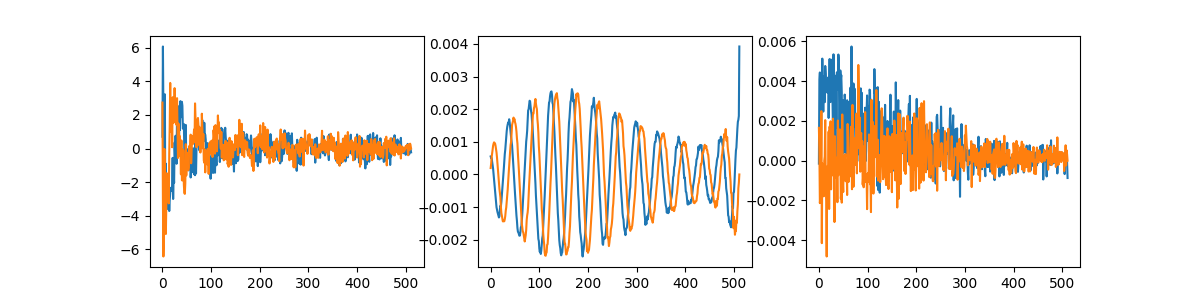

In [17]:
opt_filter = norm_pulse_fft.conj()/noise_psd/norm_factor
dH = opt_filter[1:]*fft_noisy_pulse[1:]
opt_filter
fig, axes = plt.subplot_mosaic('abc', figsize=(12, 3))
ax = axes['a']
ax.plot(fft_noisy_pulse[1:].real)
ax.plot(fft_noisy_pulse[1:].imag)
ax = axes['b']
ax.plot(opt_filter[1:].real)
ax.plot(opt_filter[1:].imag)
ax = axes['c']
ax.plot(dH.real)
ax.plot(dH.imag)

In [ ]:
fig, axes = plt.subplot_mosaic('ab', figsize=(12, 4))
ax = axes['a']
ax.plot(noisy_pulse)
ax = axes['b']
ax.plot(fft_noisy_pulse.real)
ax.plot(fft_noisy_pulse.imag)

In [ ]:
fig, axes = plt.subplot_mosaic('ab', figsize=(8, 4), constrained_layout=True)
ax = axes['a']
_ = ax.hist(H, bins=125)
ax.set_xlabel('H')
ax.set_ylabel('counts')
_ = ax.set_title('PDF pulse heights')
ax.set_xlim([0, 1])
ax = axes['b']
ax.plot(noisy_pulse, label='noisy pulse', lw=2)
ax.plot(opt_pulse, label='H x norm_pulse_model', lw=1)
ax.set_xlabel('time [$\mu s$]')
ax.set_ylabel('response')
ax.set_title('normalised mean pulse')
ax.legend()

In [ ]:
H[pulse_nr]